In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.proportion import proportion_confint
import graphviz
import os

# Function to load and preprocess the dataset
def load_and_preprocess_data(file_path, features, target, transformations=None):
    df = pd.read_csv(file_path)
    df = df.dropna(subset=features + [target]).copy()  # Avoid SettingWithCopyWarning

    # Apply transformations if any
    if transformations:
        for col, func in transformations.items():
            df[col] = func(df[col])

    # Ensure all features are numeric
    for col in features:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes

    return df

# Function to train a decision tree model
def train_decision_tree(X_train, y_train, class_weight):
    clf = DecisionTreeClassifier(
        criterion="gini",
        class_weight=class_weight,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

# Function to evaluate the model
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute recall and confidence interval
    n_ciTBI_1 = sum(y_test == 1)
    n_correct_ciTBI_1 = sum((y_test == 1) & (y_pred == 1))
    recall_ciTBI_1 = n_correct_ciTBI_1 / n_ciTBI_1 if n_ciTBI_1 > 0 else 0
    ci_low, ci_high = proportion_confint(n_correct_ciTBI_1, n_ciTBI_1, alpha=0.05, method="wilson")

    classification_rep = classification_report(y_test, y_pred, target_names=["No ciTBI", "ciTBI"], zero_division=0)

    return accuracy, recall_ciTBI_1, (ci_low, ci_high), classification_rep

# Function to visualize the decision tree and save as an image
def visualize_decision_tree(clf, feature_names, filename):
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=feature_names, class_names=["No ciTBI", "ciTBI"], filled=True, rounded=True)
    plt.savefig(filename)
    plt.show()

    # Save as Graphviz file
    dot_data = export_graphviz(
        clf, out_file=None, feature_names=feature_names,
        class_names=["No ciTBI", "ciTBI"], filled=True, rounded=True
    )
    graph = graphviz.Source(dot_data)
    graph.render(filename.replace(".png", ""), format="png", cleanup=True)

current_dir = os.path.dirname(os.path.abspath("__file__"))
file_path = os.path.join(current_dir, '..', 'data', 'TBI_cleaned.csv')
file_path2 = os.path.join(current_dir, '..', 'data', 'TBI_stability.csv')

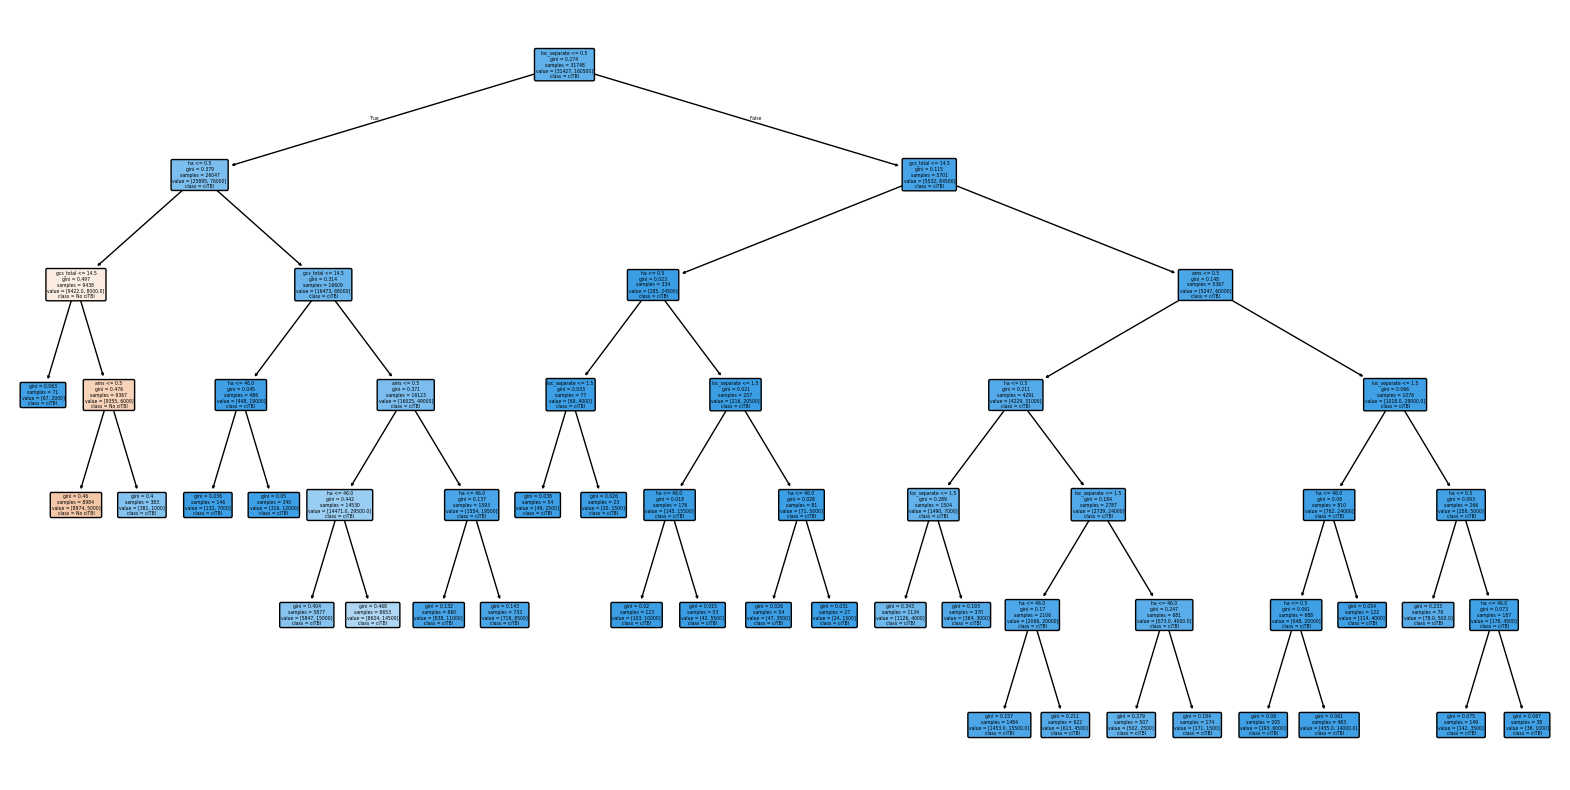


### Original Model Performance ###
Model 1 Accuracy: 0.2953
ciTBI=1 Recall: 0.9452
95% Confidence Interval: (0.8674, 0.9785)

Classification Report:
               precision    recall  f1-score   support

    No ciTBI       1.00      0.29      0.45      7865
       ciTBI       0.01      0.95      0.02        73

    accuracy                           0.30      7938
   macro avg       0.51      0.62      0.24      7938
weighted avg       0.99      0.30      0.44      7938


### Stability Check Model Performance ###
Stability Model 1 Accuracy: 0.2877
ciTBI=1 Recall: 0.9589
95% Confidence Interval: (0.8860, 0.9859)

Classification Report:
               precision    recall  f1-score   support

    No ciTBI       1.00      0.28      0.44      7865
       ciTBI       0.01      0.96      0.02        73

    accuracy                           0.29      7938
   macro avg       0.51      0.62      0.23      7938
weighted avg       0.99      0.29      0.44      7938


Prediction Change Rate: 0.

In [2]:
# First Model
features_model_1 = ['loc_separate', 'ha', 'ams', 'gcs_total']
target = 'citbi'

# Load and preprocess original data
df_model_1 = load_and_preprocess_data(file_path, features_model_1, target)

# Load and preprocess stability check data
df_model_1_stability = load_and_preprocess_data(file_path2, features_model_1, target)

# Split dataset (original)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_model_1[features_model_1], df_model_1[target], test_size=0.2, random_state=42)

# Split dataset (stability check)
X_train_1_stability, X_test_1_stability, y_train_1_stability, y_test_1_stability = train_test_split(
    df_model_1_stability[features_model_1], df_model_1_stability[target], test_size=0.2, random_state=42
)

# Train model on original data
clf_model_1 = train_decision_tree(X_train_1, y_train_1, class_weight={0: 1, 1: 500})

# Train model on stability check data
clf_model_1_stability = train_decision_tree(X_train_1_stability, y_train_1_stability, class_weight={0: 1, 1: 500})

# Evaluate original model
accuracy_1, recall_1, ci_1, classification_rep_1 = evaluate_model(clf_model_1, X_test_1, y_test_1)

# Evaluate stability check model
accuracy_1_stability, recall_1_stability, ci_1_stability, classification_rep_1_stability = evaluate_model(
    clf_model_1_stability, X_test_1_stability, y_test_1_stability
)

# Compare Predictions
y_pred_original = clf_model_1.predict(X_test_1)
y_pred_stability = clf_model_1_stability.predict(X_test_1_stability)

# Calculate Prediction Change Rate
prediction_change_rate = np.mean(y_pred_original != y_pred_stability)

# Visualize the Decision Tree for Stability Check Model
visualize_decision_tree(clf_model_1_stability, features_model_1, "../figures/decision_tree_model_1_stability.png")

# Print Results
print("\n### Original Model Performance ###")
print(f"Model 1 Accuracy: {accuracy_1:.4f}")
print(f"ciTBI=1 Recall: {recall_1:.4f}")
print(f"95% Confidence Interval: ({ci_1[0]:.4f}, {ci_1[1]:.4f})")
print("\nClassification Report:\n", classification_rep_1)

print("\n### Stability Check Model Performance ###")
print(f"Stability Model 1 Accuracy: {accuracy_1_stability:.4f}")
print(f"ciTBI=1 Recall: {recall_1_stability:.4f}")
print(f"95% Confidence Interval: ({ci_1_stability[0]:.4f}, {ci_1_stability[1]:.4f})")
print("\nClassification Report:\n", classification_rep_1_stability)

print(f"\nPrediction Change Rate: {prediction_change_rate:.4f}")


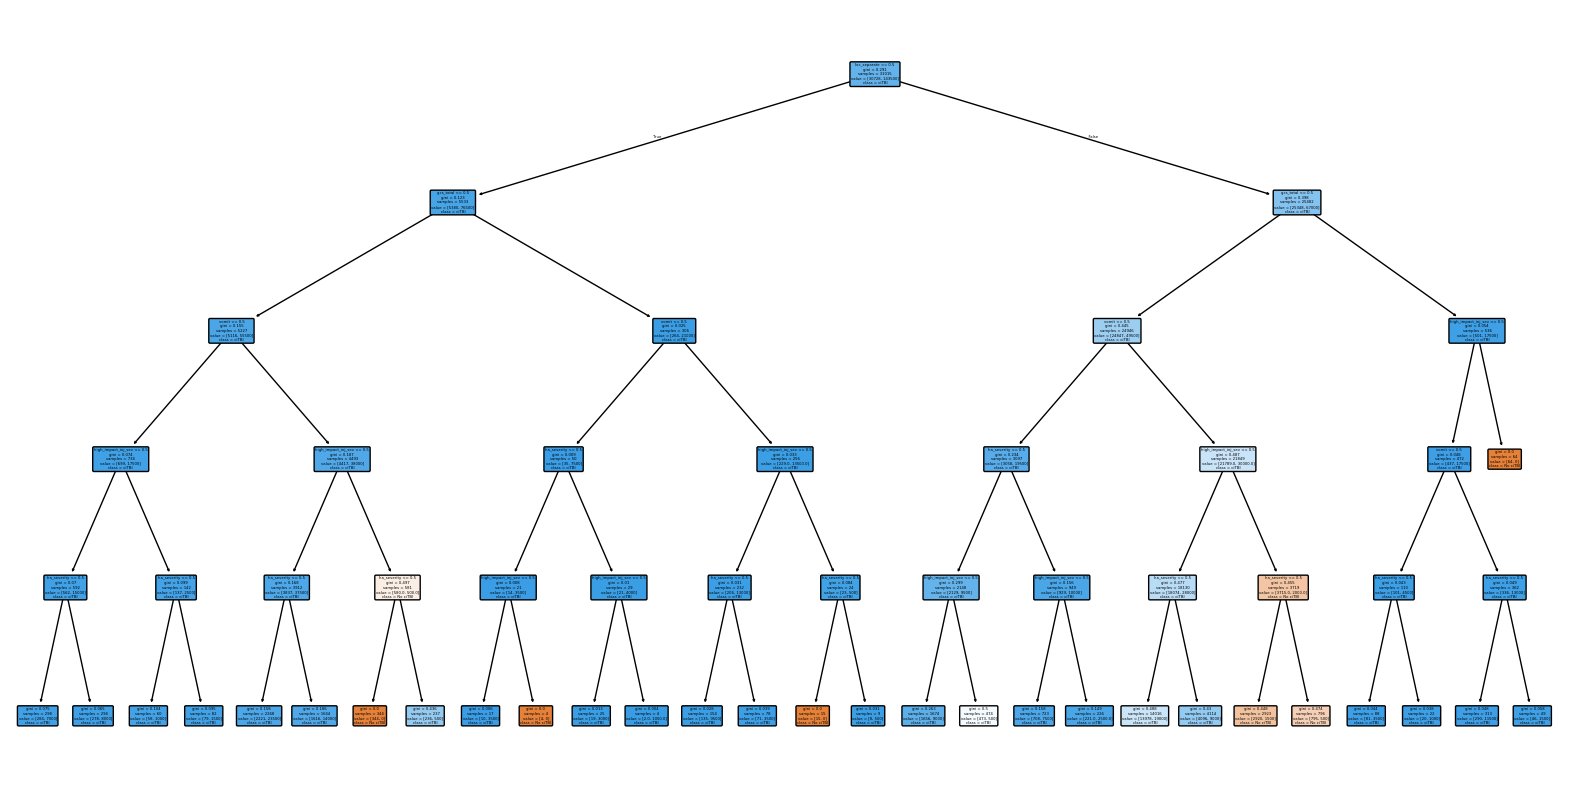


### Original Model Performance ###
Model 2 Accuracy: 0.1469
ciTBI=1 Recall: 0.9722
95% Confidence Interval: (0.9043, 0.9923)

Classification Report:
               precision    recall  f1-score   support

    No ciTBI       1.00      0.14      0.24      7682
       ciTBI       0.01      0.97      0.02        72

    accuracy                           0.15      7754
   macro avg       0.50      0.56      0.13      7754
weighted avg       0.99      0.15      0.24      7754


### Stability Check Model Performance ###
Stability Model 2 Accuracy: 0.1465
ciTBI=1 Recall: 0.9722
95% Confidence Interval: (0.9043, 0.9923)

Classification Report:
               precision    recall  f1-score   support

    No ciTBI       1.00      0.14      0.24      7682
       ciTBI       0.01      0.97      0.02        72

    accuracy                           0.15      7754
   macro avg       0.50      0.56      0.13      7754
weighted avg       0.99      0.15      0.24      7754


Prediction Change Rate: 0.

In [3]:
# Second Model
features_model_2 = ['gcs_total', 'loc_separate', 'vomit', 'ha_severity', 'high_impact_inj_sev']
transformations = {
    'gcs_total': lambda x: (x < 15).astype(int),
    'loc_separate': lambda x: (x == 0).astype(int),
    'vomit': lambda x: (x == 0).astype(int),
    'ha_severity': lambda x: (x < 3).astype(int),
    'high_impact_inj_sev': lambda x: (x == 1).astype(int)
}

# Load and preprocess data for model 2 (original and stability check)
df_model_2 = load_and_preprocess_data(file_path, features_model_2, target, transformations)
df_model_2_stability = load_and_preprocess_data(file_path2, features_model_2, target, transformations)

# Ensure both datasets have the same number of rows
n_samples = min(len(df_model_2), len(df_model_2_stability))

# Trim both datasets to the same size
df_model_2 = df_model_2.sample(n=n_samples, random_state=42).reset_index(drop=True)
df_model_2_stability = df_model_2_stability.sample(n=n_samples, random_state=42).reset_index(drop=True)

# Split dataset (original)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_model_2[features_model_2], df_model_2[target], test_size=0.2, random_state=42, stratify=df_model_2[target]
)

# Split dataset (stability check)
X_train_2_stability, X_test_2_stability, y_train_2_stability, y_test_2_stability = train_test_split(
    df_model_2_stability[features_model_2], df_model_2_stability[target], test_size=0.2, random_state=42, stratify=df_model_2_stability[target]
)

# Train model on original data
clf_model_2 = train_decision_tree(X_train_2, y_train_2, class_weight={0: 1, 1: 500})

# Train model on stability check data
clf_model_2_stability = train_decision_tree(X_train_2_stability, y_train_2_stability, class_weight={0: 1, 1: 500})

# Evaluate original model
accuracy_2, recall_2, ci_2, classification_rep_2 = evaluate_model(clf_model_2, X_test_2, y_test_2)

# Evaluate stability check model
accuracy_2_stability, recall_2_stability, ci_2_stability, classification_rep_2_stability = evaluate_model(
    clf_model_2_stability, X_test_2_stability, y_test_2_stability
)

# Compare Predictions
y_pred_original = clf_model_2.predict(X_test_2)
y_pred_stability = clf_model_2_stability.predict(X_test_2_stability)

# Ensure same shape
n_common_samples = min(len(y_pred_original), len(y_pred_stability))
y_pred_original = y_pred_original[:n_common_samples]
y_pred_stability = y_pred_stability[:n_common_samples]

# Calculate Prediction Change Rate
prediction_change_rate = np.mean(y_pred_original != y_pred_stability)

# Visualize the Decision Tree for Stability Check Model
visualize_decision_tree(clf_model_2_stability, features_model_2, "../figures/decision_tree_model_2_stability.png")

# Print Results
print("\n### Original Model Performance ###")
print(f"Model 2 Accuracy: {accuracy_2:.4f}")
print(f"ciTBI=1 Recall: {recall_2:.4f}")
print(f"95% Confidence Interval: ({ci_2[0]:.4f}, {ci_2[1]:.4f})")
print("\nClassification Report:\n", classification_rep_2)

print("\n### Stability Check Model Performance ###")
print(f"Stability Model 2 Accuracy: {accuracy_2_stability:.4f}")
print(f"ciTBI=1 Recall: {recall_2_stability:.4f}")
print(f"95% Confidence Interval: ({ci_2_stability[0]:.4f}, {ci_2_stability[1]:.4f})")
print("\nClassification Report:\n", classification_rep_2_stability)

print(f"\nPrediction Change Rate: {prediction_change_rate:.4f}")